# **EVALUATION**

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.utils import to_categorical
from tensorflow.keras.models import load_model
from glob import glob
from sklearn import preprocessing
import tensorflow as tf
from keras import backend as K
import math
tf.config.run_functions_eagerly(True)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Custom Metrics

In [3]:
def dice_coef(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_multilabel(y_true, y_pred, numLabels = 6):
    dice = 0
    weights = [0.17649986,  7.78453571, 41.53978194, 65.20657672, 96.75504125,  6.40743063]
    for index in range(numLabels):
        dice += dice_coef(y_true[:,:,index], y_pred[:,:,index]) * weights[index]
    return dice/np.sum(weights)

def dice_coef_multilabelloss(y_true, y_pred):
    return 1 - dice_coef_multilabel(y_true, y_pred)

def weightedLoss(originalLossFunc, weightsList):

    def lossFunc(true, pred):
        true = K.cast(true, K.floatx())
        pred = K.cast(pred, K.floatx())

        axis = -1 #if channels last
          #axis=  1 #if channels first


          #argmax returns the index of the element with the greatest value
          #done in the class axis, it returns the class index
        classSelectors = K.argmax(true, axis=axis)
              #if your loss is sparse, use only true as classSelectors

          #considering weights are ordered by class, for each class
          #true(1) if the class index is equal to the weight index
          #weightsList = tf.cast(weightsList, tf.int64)
        classSelectors = [K.equal(tf.cast(i, tf.int64), tf.cast(classSelectors, tf.int64)) for i in range(len(weightsList))]

          #casting boolean to float for calculations
          #each tensor in the list contains 1 where ground true class is equal to its index
          #if you sum all these, you will get a tensor full of ones.
        classSelectors = [K.cast(x, K.floatx()) for x in classSelectors]

          #for each of the selections above, multiply their respective weight
        weights = [sel * w for sel,w in zip(classSelectors, weightsList)]

          #sums all the selections
          #result is a tensor with the respective weight for each element in predictions
        weightMultiplier = weights[0]
        for i in range(1, len(weights)):
            weightMultiplier = weightMultiplier + weights[i]


          #make sure your originalLossFunc only collapses the class axis
          #you need the other axes intact to multiply the weights tensor
        loss = originalLossFunc(true,pred)
        loss = loss * weightMultiplier

        return loss
    return lossFunc

## Function to process models evaluation

In [4]:
def Evaluation_report(path, models_to_evaluate, patient_data, index, custom_objects=None, show_graph=False):

  def __process_data__(Y):
    train_masks_cat = to_categorical(Y, num_classes=6)
    y_categorical = train_masks_cat.reshape((Y.shape[0], Y.shape[1], Y.shape[2], 6))
    return y_categorical

  def __dice_coef__(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

  def __show_graphic__(data):
    mean_iou = data["Mean_IoU"][0]
    dice_coef = data["Dice_coef"][0]

    names = ["Mean IoU", "Dice Coef"]
    values = [mean_iou, dice_coef]

    plt.bar(names, values, width=0.5)
    plt.ylabel('Values')
    plt.title('Mean IoU vs Dice Coef')
    plt.show()

  def __show_prediction__(X_val, y_val, y_pred_argmax, idx):
    index = idx

    fig, axes = plt.subplots(1, 3, figsize=(10, 4))

    axes[0].imshow(X_val[index,:,:], cmap='gray')
    axes[0].set_title('Slice')
    axes[0].grid(False)

    axes[1].imshow(y_val[index,:,:], cmap='jet')
    axes[1].set_title('Ground truth')
    axes[1].grid(False)

    axes[2].imshow(y_pred_argmax[index,:,:], cmap='jet')
    axes[2].set_title('Prediction')
    axes[2].grid(False)

    plt.tight_layout()
    plt.show()

  for i, model_path in enumerate(models_to_evaluate):
    try:
      model = load_model(os.path.join(path, model_path))
    except:
      model = load_model(os.path.join(path, model_path), custom_objects=custom_objects)

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=tf.keras.metrics.MeanIoU(num_classes=6))

    with open(patient_data, 'rb') as f:
      X_val = np.load(f, allow_pickle = True)
      y_val = np.load(f, allow_pickle = True)

    y_cat = __process_data__(y_val)

    evaluation = model.evaluate(X_val, y_cat)
    y_pred = model.predict(X_val)
    y_pred_argmax=np.argmax(y_pred, axis=3)
    dice = __dice_coef__(y_cat, y_pred)

    metrics = {"Loss":[evaluation[0]], "Mean_IoU":[evaluation[1]], "Dice_coef":[dice.numpy()]}
    metrics = pd.DataFrame.from_dict(metrics)
    print("\n")
    print(f"Evaliuation Metrics Result {model_path}: \n")
    print(metrics, "\n")

    __show_prediction__(X_val, y_val, y_pred_argmax, index)
    if show_graph != False:
      __show_graphic__(metrics)


/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 1s 66ms/step


Evaliuation Metrics Result Unet_Fine_Tune_128_plus_CKP.h5: 

       Loss  Mean_IoU  Dice_coef
0  0.092787  0.739236   0.619256 



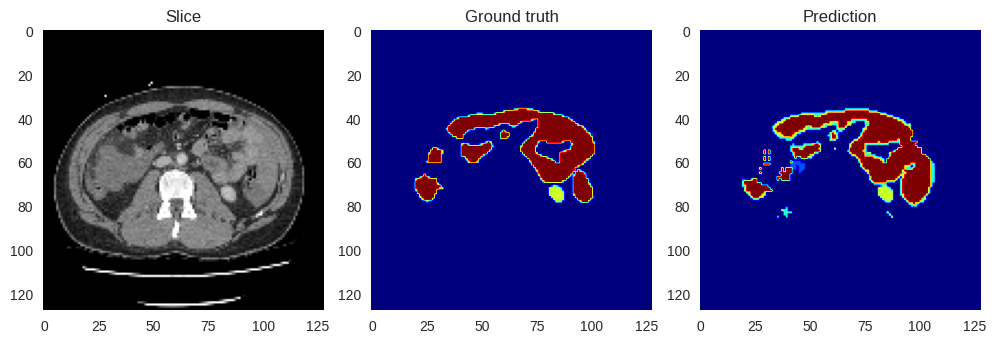

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 1s 66ms/step


Evaliuation Metrics Result UnetV_128_epochs.h5: 

       Loss  Mean_IoU  Dice_coef
0  0.194845  0.660987   0.591757 



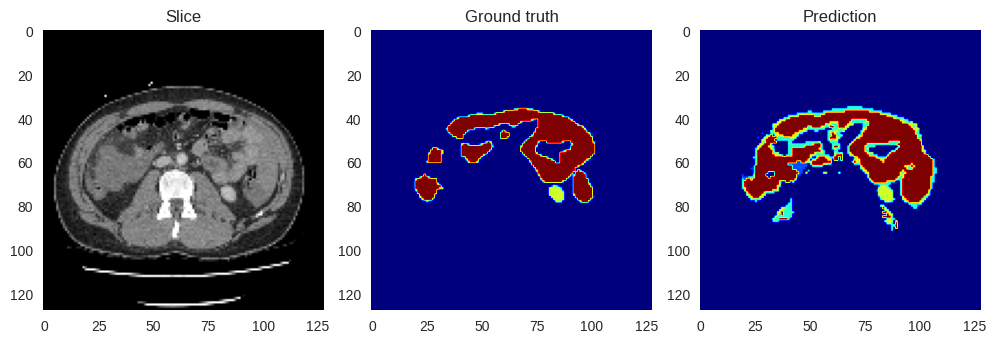

/usr/local/lib/python3.10/dist-packages/tensorflow/python/data/ops/structured_function.py:265: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


22/22 [==============================] - 1s 66ms/step


Evaliuation Metrics Result UnetV_128_epochs_IoUonly.h5: 

       Loss  Mean_IoU  Dice_coef
0  0.194598  0.661189   0.591837 



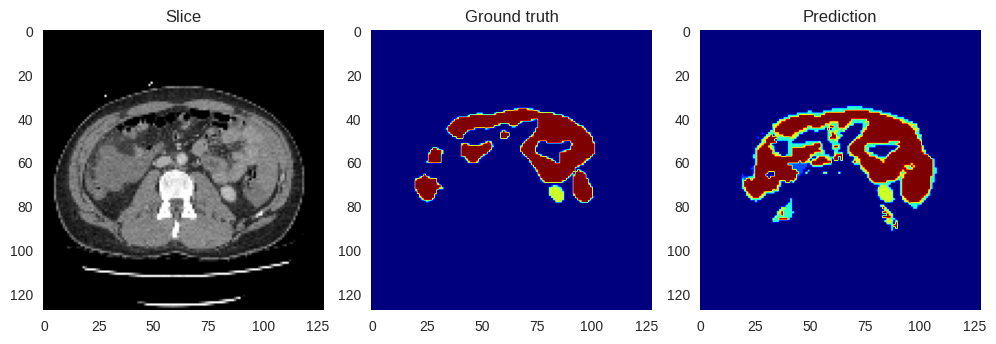

In [ ]:
custom_objects = {'lossFunc': weightedLoss, 'dice_coef_multilabel': dice_coef_multilabel}
path = "/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/"
models = ['Unet_Fine_Tune_128_plus_CKP.h5', 'UnetV_128_epochs.h5', 'UnetV_128_epochs_IoUonly.h5']
data = '/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Data/Validation_data/X_y_65504_55928_.npy'


Evaluation_report(path, models, data, index=300, custom_objects=custom_objects)

## Prediction Visualization

Considering the best model so far -> Unet_Fine_Tune_128_plus_CKP.h5

**Model characteristics:**
* Fine Tuned model for 128 epochs
* Batch size = 64
* Trained on a 15,500 images dataset

In [24]:
from mpl_toolkits.mplot3d import Axes3D

def __plot_predictions__(path, model_path, patient_data, class_to_plot=None):

  def __process_data__(Y):
    train_masks_cat = to_categorical(Y, num_classes=6)
    y_categorical = train_masks_cat.reshape((Y.shape[0], Y.shape[1], Y.shape[2], 6))
    return y_categorical

  model = load_model(os.path.join(path, model_path))

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000001),
              loss=tf.keras.losses.categorical_crossentropy,
              metrics=tf.keras.metrics.MeanIoU(num_classes=6))

  with open(patient_data, 'rb') as f:
      X_val = np.load(f, allow_pickle = True)
      y_val = np.load(f, allow_pickle = True)

  y_cat = __process_data__(y_val)
  y_pred = model.predict(X_val)
  y_pred_argmax=np.argmax(y_pred, axis=3)

  class_colors = {
        1: 'green',
        2: 'red',
        3: 'cyan',
        4: 'magenta',
        5: 'yellow'
    }

    # Create a figure with two subplots
  fig, axes = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

  if class_to_plot != None:
        # Plot real segmentation for the specified class
      if class_to_plot in class_colors:
          real_coords = np.argwhere(y_val == class_to_plot)
          axes[0].scatter(real_coords[:, 0], real_coords[:, 1], real_coords[:, 2],
                            color=class_colors[class_to_plot], label=f'Real Class {class_to_plot}')
          axes[0].set_title(f'Real Segmentation (Class {class_to_plot})')
      else:
          print(f"Class {class_to_plot} not found in the class colors dictionary.")

        # Plot predicted segmentation for the specified class
      if class_to_plot in class_colors:
          predicted_coords = np.argwhere(y_pred_argmax == class_to_plot)
          axes[1].scatter(predicted_coords[:, 0], predicted_coords[:, 1], predicted_coords[:, 2],
                            color=class_colors[class_to_plot], marker='x', label=f'Predicted Class {class_to_plot}')
          axes[1].set_title(f'Predicted Segmentation (Class {class_to_plot})')
      else:
          print(f"Class {class_to_plot} not found in the class colors dictionary.")
  else:
        # Plot all classes if class_to_plot is not specified
      for class_label, color in class_colors.items():
            # Plot real segmentation
          real_coords = np.argwhere(y_val == class_label)
          axes[0].scatter(real_coords[:, 0], real_coords[:, 1], real_coords[:, 2],
                            color=color, label=f'Real Class {class_label}')
          axes[0].set_title('Real Segmentation')
          axes[0].legend()

            # Plot predicted segmentation
          predicted_coords = np.argwhere(y_pred_argmax == class_label)
          axes[1].scatter(predicted_coords[:, 0], predicted_coords[:, 1], predicted_coords[:, 2],
                            color=color, marker='x', label=f'Predicted Class {class_label}')
          axes[1].set_title('Predicted Segmentation')
          axes[1].legend()

  axes[0].set_xlabel('X Axis')
  axes[0].set_ylabel('Y Axis')
  axes[0].set_zlabel('Z Axis')
  axes[1].set_xlabel('X Axis')
  axes[1].set_ylabel('Y Axis')
  axes[1].set_zlabel('Z Axis')

  plt.show()

24/24 [==============================] - 1s 62ms/step


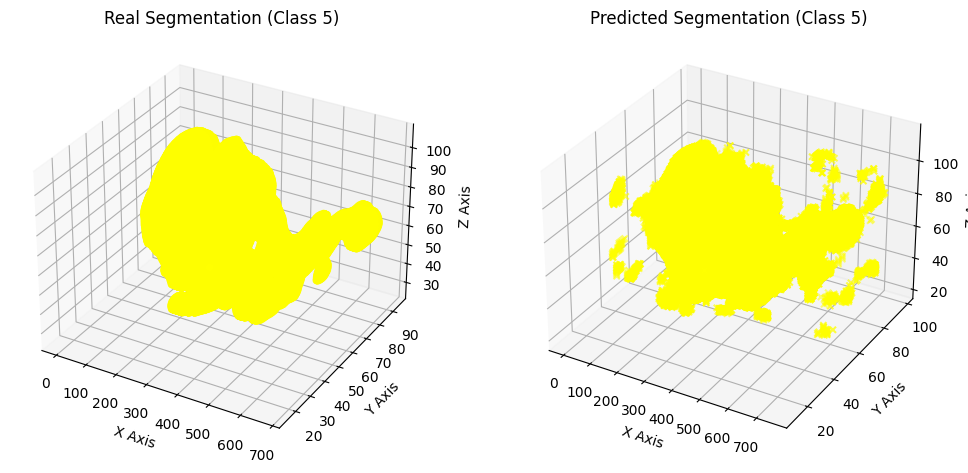

In [27]:
path = "/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Models/"
model = 'Unet_Fine_Tune_128_plus_CKP.h5'
data = '/content/drive/MyDrive/RSNA_Abdominal_Trauma_Segmentations/Data/Validation_data/X_y_7642_778_.npy'


__plot_predictions__(path=path, model_path=model, patient_data=data, class_to_plot=5)